Missing values found in the test data.
The 'Id' column is present in the test data.
Mean Squared Error: 2641205374.233925
Root Mean Squared Error: 51392.65875817211
R-squared: 0.6556593157981854
Accuracy: 65.57%


<ipython-input-11-be2cfc5b73a4>:113: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data_encoded['SalePrice'] = y_test_pred


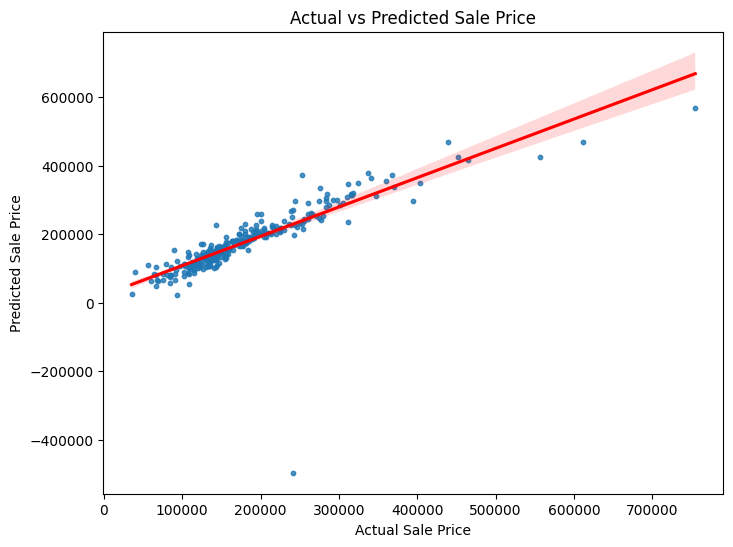

In [11]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Loading the data
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

# Displaying the first few rows of the training data
train_data.head()

# Checking for missing values
train_data.isnull().sum()

# Handling missing values separately for numeric and categorical columns
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
categorical_columns = train_data.select_dtypes(exclude=[np.number]).columns

# Exclude the target variable ('SalePrice') from the list of numeric columns for filling missing values
numeric_columns = numeric_columns[numeric_columns != 'SalePrice']

# Fill missing numeric values with the median
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())
test_data[numeric_columns] = test_data[numeric_columns].fillna(test_data[numeric_columns].median())

# Fill missing categorical values with the mode (most frequent value)
train_data[categorical_columns] = train_data[categorical_columns].fillna(train_data[categorical_columns].mode().iloc[0])
test_data[categorical_columns] = test_data[categorical_columns].fillna(test_data[categorical_columns].mode().iloc[0])

# Selecting features and target variable
features = [
    'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour',
    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
    'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
    'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
    'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
    'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
]

target = 'SalePrice'

# Including the 'Id' column before encoding
train_data_encoded = pd.get_dummies(train_data[features], drop_first=True)
test_data_encoded = pd.get_dummies(test_data[features], drop_first=True)

# Keeping the 'Id' column separate and adding it back after encoding
train_data_encoded['Id'] = train_data['Id']
test_data_encoded['Id'] = test_data['Id']

# Aligning the columns of train and test data (in case some columns are missing in either)
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='left', axis=1)

# Check if there are missing values in the test data and handle them
if test_data_encoded.isnull().sum().any():
    print("Missing values found in the test data.")
    # Fill missing values in the test data (e.g., with mean of the respective columns)
    test_data_encoded = test_data_encoded.fillna(train_data_encoded.mean())

# Verify that 'Id' column exists before scaling
if 'Id' in test_data_encoded.columns:
    print("The 'Id' column is present in the test data.")
else:
    print("The 'Id' column is missing in the test data.")

# Splitting the data into training and validation sets
X = train_data_encoded.drop('Id', axis=1)
y = train_data[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data (Standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Training a Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predicting on validation data
y_val_pred = model.predict(X_val_scaled)

# Evaluating the model
mse = mean_squared_error(y_val, y_val_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_val_pred)

# Calculating accuracy percentage
accuracy_percentage = r2 * 100

# Print evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print(f"Accuracy: {accuracy_percentage:.2f}%")

# Predicting on the test data
X_test_scaled = scaler.transform(test_data_encoded.drop('Id', axis=1))  # Drop 'Id' column before scaling
y_test_pred = model.predict(X_test_scaled)

# Saving the predictions in a CSV file
test_data_encoded['SalePrice'] = y_test_pred
test_data_encoded[['Id', 'SalePrice']].to_csv('house_price_predictions.csv', index=False)

# Visualizing the results (Actual vs Predicted Sale Price)
plt.figure(figsize=(8, 6))
sns.regplot(x=y_val, y=y_val_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Price")
plt.show()
